In [82]:
##Load all the required libraries...

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.optimize import curve_fit
import time

from tools.base import *
from tools.ddmtd import ddmtd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
## set the ip address of the raspberry pi
server="pi@192.168.222.128" # your ip address might be different

## IMPORTANT##
## make sure you have your ssh keys set-up properly
## END IMPORTANT##
## Contact rohith.saradhy@cern.ch for password to the RPi

In [5]:
#Copy Flash_Firmware scripts to the Raspberry Pi.
!rsync -ra ../RPi_Side/Flash_Firmware {server}:

## Do not turn of the chip while next cell is running

In [84]:
## Flash The Firmware to the Nexys Board flash memory
## Physically restart the Nexys Board after the flash. Or click the "PROG" button on Nexys Video Board.

!../RPi_Side/Flash_Nex.sh ../RPi_Side/HEX_Files/2020_11_3_main_v2001.hex {server}

#If "chip ID incorrect" error occurs, repeat the process

# Successfull Flashing would look similar to the following:
# We are in dir::/home/pi/Flash_Firmware

# 	FLASH MEMORY WRITE

# Current Chip ID: 010219

# Reading hex file:	 Success
# Number of Bytes: 	 2161808
# Erasing sectors: 	 Success 
# Flashing memory: 	 Success 

# The flash memory was successfully written.

 

2020_11_3_main_v2001.hex                      100% 4503KB  21.1MB/s   00:00    
We are in dir::/home/pi/Flash_Firmware

	FLASH MEMORY WRITE

Current Chip ID: 010219

Reading hex file:	 Success
Number of Bytes: 	 2305652
Erasing sectors: 	 Success 
Flashing memory: 	 Success 

The flash memory was successfully written.


### RESTART NEXYS BOARD 

In [9]:
#Check Version Number
!../RPi_Side/runAtNex.sh check_firmware.exe 0 1 {server} #flash the configuration file
# Should return: 
# FirmwareVersion::2.001

Scipt Location::/home/rsaradhy/Work/ddmtd_nexys_toolkit/RPi_Side
FirmwareVersion::2.001


In [10]:
#Look at available configs
!ls ../RPi_Side/PLL_Conf/


160MHz_100k.h  40MHz_100k.h  640MHz_100k.h
160MHz_10k.h   40MHz_10k.h   README.md


In [23]:
## Configuring the PLL. This needs to be done everytime the board is restarted/ loses power.
N=100000 #Setting the DDMTD N
freq = 160#Setting the input clock frequency



##Selecting the Register File##
config_loc = f"../RPi_Side/PLL_Conf/{freq}MHz_{int(N/1000)}k.h" #Selecting the configuration according to N, freq
!scp {config_loc} {server}:Flash_Firmware/Si5344_REG.h #Copy the config to the RPi as Si5344
    
    
## Compile and Running configuration script
!../RPi_Side/runAtNex.sh ddmtd_pll.exe 1 1 {server} #flash the configuration file

#The output should look like the following::
# Done Compiling MEM
# Done Compiling PLL
# address = 0x0514, value = 0x01 ; Value returned = 0x00   
# address = 0x001c, value = 0x01 ; Value returned = 0x00 

# After configuration, D304 will blink every 500 cycles of the beat clock

160MHz_100k.h                                 100%   43KB  10.3MB/s   00:00    
Scipt Location::/home/rsaradhy/Work/ddmtd_nexys_toolkit/RPi_Side
Done Compiling data_acq
Done Compiling PLL
address = 0x0514, value = 0x01 ; Value returned = 0x00   
address = 0x001c, value = 0x01 ; Value returned = 0x00   


In [24]:
#Before collecting data we need to set the save directories for the data
# and figures

fig_save_folder = f"./test/figures/N{N}/"
data_save_folder = f"./test/data/N{N}/"
!mkdir -p {fig_save_folder} #create those directories
!mkdir -p {data_save_folder} #create those directories


In [55]:
cycle = 20 # number of times to collect 64k edges.
save_name  = f"testRun1" #measurement name
save_file=data_save_folder+save_name+".txt"
# print (save_name)
# print (save_file)
DataAq(cycle,server,data_save_folder,save_name,compiles=1) #Acquires the data and stores it as text files...

Scipt Location::/home/rsaradhy/Work/ddmtd_nexys_toolkit/RPi_Side
Done Compiling data_acq
Done Compiling PLL



In [56]:
#This Code Cell does the same as previous code cell, you can use this to debug
# cycle = 40  #number of times to collect 60k edges.
# compiles =1

# save_name  = f"testRun1" #measurement name
# save_file=data_save_folder+save_name+".txt"


# !../RPi_Side/runAtNex.sh data_acq.exe {compiles} {cycle} {server}
# !scp {server}:Flash_Firmware/ddmtd1.txt  {data_save_folder+save_name+"_ddmtd1.txt"}
# !scp {server}:Flash_Firmware/ddmtd2.txt  {data_save_folder+save_name+"_ddmtd2.txt"}    

In [57]:
# Raw data should be saved on your computer
# Check this
!ls {data_save_folder+save_name}_ddmtd*

./test/data/N100000/testRun1_ddmtd1.txt
./test/data/N100000/testRun1_ddmtd2.txt


data in ddmtd1 corresponds to CLK-A <br>
data in ddmtd2 corresponds to CLK-B



In [58]:
# Create a DDMTD Object for analysis of the data
data = ddmtd(data_save_folder+save_name) #creates a ddmtd object

In [59]:
#Setting the correct N can recalculating all the scalings
data.N = N  
data.INPUT_FREQ = freq*10**6 #In Hz 
data.Recalc()


Recalculations Done.
N = 100000
Input Freq = 160.0 MHz
PLL Freq = 159.99840001599986 MHz
BEAT Freq = 1.5999840001599985 kHz
Err = 0.0625 ps
$$$$$$$$$$$$ Recovered Beat Freq $$$$$$$$$$$$
BEAT Freq DDMTD1 = 1.5999570562900929 kHz
BEAT Freq DDMTD2 = 1.5999623925380517 kHz
Recovered N of DDMTD1 = 100001.68403706835
Recovered N of DDMTD2 = 100001.35050811492


3.1399258272058823
[ 2.49461674e+04  3.13993028e+00 -4.96265046e-04]


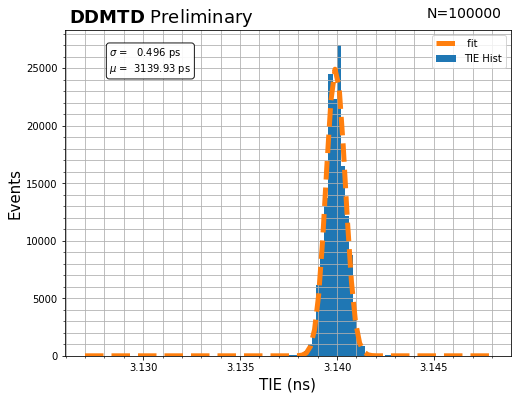

In [60]:
binx=(np.arange(np.min(data.TIE_fall),np.max(data.TIE_fall),1))*data.MULT_FACT
data.drawTIE(sep="fall",bns=binx,fit=True,save_name=f"{fig_save_folder}{save_name}_TIE_{edge}.png")

In [61]:
type(binx)

numpy.ndarray

3.1221027403846158
[2.38868719e+04 3.12233115e+00 4.81155729e-04]
3.1399258272058823
[ 2.49461674e+04  3.13993028e+00 -4.96265046e-04]


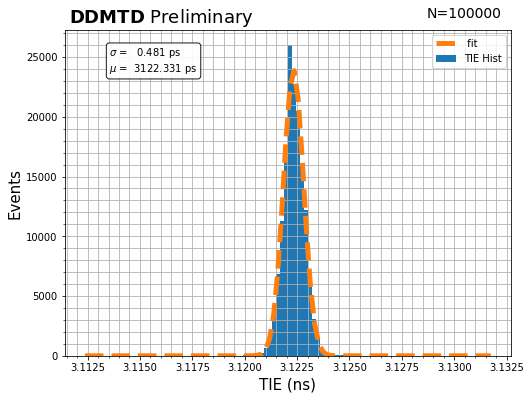

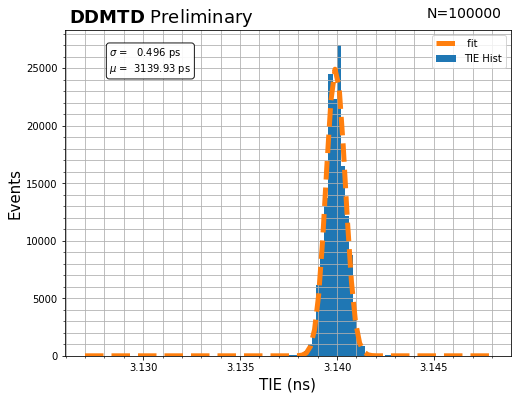

In [62]:
# Rising Edge Time Interval Error
edge="rise"
data.drawTIE(sep=edge,fit=True,save_name=f"{fig_save_folder}{save_name}_TIE_{edge}.png")
# Falling Edge Time Interval Error
edge="fall"
data.drawTIE(sep=edge,fit=True,save_name=f"{fig_save_folder}{save_name}_TIE_{edge}.png")
# Both Edge Time Interval Error
# edge="all"
# data.drawTIE(sep=edge,fit=True,save_name=f"{fig_save_folder}{save_name}_TIE_{edge}.png")

 The peak: 0.04399280375875601,[1525.48159249]


(0.04399280375875601, 1525.4815924902575)

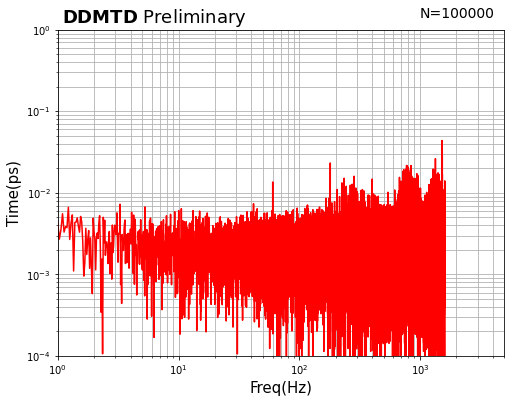

In [63]:
## Doing a FFT

data.FFT(ylim=(0.0001,1),
         xlim=(1,5000.0),
         disp=1,
         save_name=f"{fig_save_folder}{save_name}_FFT.png")